In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import copy
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

print(sorted(plt.rcParams.keys()))
config = {
    'font.size':12.0,
    'font.family':['DejaVu Serif'],
    'mathtext.fontset':'dejavuserif',
    'mathtext.rm':'DejaVu Serif',
    'figure.figsize':[6.4, 4.8], # default is [6.4, 4.8],
    'xtick.major.size':3.5,
    'ytick.major.size':3.5,
}
plt.rcParams.update(config)
cmap = copy.copy(plt.get_cmap('RdBu_r')) # RdBu_r, Blues, GnBu, PuBu

plev = np.array([
13.576     , 11.115     , 9.1001     , #3
7.4506     , 6.1000     , 4.9943     , #6
4.0890     , 3.3478     , 2.7409     , #9
2.2441     , 1.8373     , 1.5042     , #12
1.2316     , 1.0083     , 0.82555    , #15
0.67590    , 0.55338    , 0.45307    , #18
0.37094    , 0.30370    , 0.24865    , #21
0.20358    , 0.16667    , 0.13646    , #24
0.11173    , 9.14730E-02, 7.48918E-02, #27
6.13162E-02, 5.02015E-02, 4.11015E-02, #30
3.36510E-02, 2.75511E-02, 2.25570E-02, #33
1.84681E-02, 1.51204E-02, 1.23795E-02, #36
1.01355E-02, 8.29825E-03, 6.79403E-03, #39
5.56248E-03, 4.55417E-03, 3.72864E-03, #42
3.05275E-03, 2.49938E-03, 2.04632E-03, #45
1.67539E-03, 1.37169E-03, 1.12304E-03, #48
9.19472E-04, 7.52800E-04, 6.16340E-04, #51
5.04617E-04, 4.13145E-04, 3.38255E-04, #54
2.76940E-04, 2.26739E-04, 1.85638E-04, #57
1.51988E-04, 1.24437E-04, 1.01880E-04, #60
8.34126E-05, 6.82925E-05, 5.59131E-05, #63
4.57778E-05, 3.74797E-05, 3.06858E-05, #66
2.51234E-05, 2.05693E-05, 1.68407E-05, #69
1.37880E-05
])
layers = np.array([
#0.000000, 
0.001000, 0.002600,
0.005160, 0.009256, 0.015810,
0.026295, 0.043073, 0.069916,
0.112866, 0.181585, 0.291536,
0.467458, 0.748933, 1.199293,
1.919869, 3.072791, 4.917465,
7.868944, 12.591311, 20.147097
])

['_internal.classic_mode', 'agg.path.chunksize', 'animation.avconv_args', 'animation.avconv_path', 'animation.bitrate', 'animation.codec', 'animation.convert_args', 'animation.convert_path', 'animation.embed_limit', 'animation.ffmpeg_args', 'animation.ffmpeg_path', 'animation.frame_format', 'animation.html', 'animation.html_args', 'animation.writer', 'axes.autolimit_mode', 'axes.axisbelow', 'axes.edgecolor', 'axes.facecolor', 'axes.formatter.limits', 'axes.formatter.min_exponent', 'axes.formatter.offset_threshold', 'axes.formatter.use_locale', 'axes.formatter.use_mathtext', 'axes.formatter.useoffset', 'axes.grid', 'axes.grid.axis', 'axes.grid.which', 'axes.labelcolor', 'axes.labelpad', 'axes.labelsize', 'axes.labelweight', 'axes.linewidth', 'axes.prop_cycle', 'axes.spines.bottom', 'axes.spines.left', 'axes.spines.right', 'axes.spines.top', 'axes.titlepad', 'axes.titlesize', 'axes.titleweight', 'axes.unicode_minus', 'axes.xmargin', 'axes.ymargin', 'axes3d.grid', 'backend', 'backend_fall

In [2]:
def localtime_aligner(dat,nx,deg):
    dat_local = np.zeros_like(dat)
    j=0 # initialize
    for i in range(nx):
        if (abs(15*j-deg*i) < 7.5):
            dat_local[:,:,:,:,:,:,i] = np.roll(dat[:,:,:,:,:,:,i], -24+j, axis=3)
        else:
            j=j+1
            dat_local[:,:,:,:,:,:,i] = np.roll(dat[:,:,:,:,:,:,i], -24+j, axis=3)
    return dat_local

def day_average(dat): # data.shape should be [nf,nv,nd,nt,nz,ny,nx]
    return np.mean(dat, axis=2)

def roll_longitude(dat,nx):
    return np.roll(dat, int(nx/2), axis=-1)

def zonal_mean(dat):
    return np.mean(dat, axis=-1)

R = 188.9       # 空気の気体定数 [J/(kg K)]
g = 3.72        # 重力加速度 [m/s^2]

def pvel_to_w(omega, rho): # 単位変換
    w = - omega * 1e2 / (rho * g)
    return w

def draw_map(ncols,nrows,titles,nx,ny,Z,cmap,levels,labels):
    plt.rcParams['figure.figsize'] = [6.4*ncols, 4.8*nrows]
    plt.rcParams['figure.autolayout'] = True
    fig,axes = plt.subplots(nrows=nrows, ncols=ncols)
    for i in range(ncols*nrows):
        k,j=i%ncols,int(i/ncols) # k: files or time series, j:variables
        print('k,j,i = ', k,j,i)
        if (ncols==1 and nrows==1):
            ax=axes
        elif (ncols==1):
            ax=axes[j]
        elif (nrows==1):
            ax=axes[k]
        else:
            ax=axes[j,k]
        cmap = copy.copy(plt.get_cmap(cmap)) # RdBu_r, Blues, GnBu, PuBu
        norm = colors.BoundaryNorm(levels[j], ncolors=cmap.N)
        time = j*int(24/nrows)+2
        mappable = ax.contourf(
            np.linspace(-180,180,nx), np.linspace(-90,90,ny)[::-1], Z[k,time,:,:],
            extend='both', cmap=cmap, levels=levels[j], norm=norm
        )
        plt.colorbar(mappable, ax=ax, orientation='horizontal', ticks=levels[j][::5]
                     ).set_label(labels[j])
        ax.set_xticks(np.linspace(-180,180,7))
        ax.set_yticks(np.linspace(-90,90,7))
        ax.set_xlabel('Longitude [°]')
        ax.set_ylabel('Latitude [°]')
        ax.set_title(str(time)+':00 LT, '+titles[k])
    plt.savefig('draw_map_'+titles[k]+'.pdf', dpi=300)
#    plt.show()
    return 

def draw_crosssection_xz(ncols,nrows,titles,nx,plev,Z,C,cmap,levels,contours,labels,step,U,W,vertical_exag,figname):
    plt.rcParams['figure.figsize'] = [6.4*ncols, 4.8*nrows]
    plt.rcParams['figure.autolayout'] = True
    fig,axes = plt.subplots(nrows=nrows, ncols=ncols)
    for i in range(ncols*nrows):
        k,j=i%ncols,int(i/ncols)
        print('k,j,i = ', k,j,i)
        if (ncols==1 and nrows==1):
            ax=axes
        elif (ncols==1):
            ax=axes[j]
        elif (nrows==1):
            ax=axes[k]
        else:
            ax=axes[j,k]
        cmap = copy.copy(plt.get_cmap(cmap)) # RdBu_r, Blues, GnBu, PuBu
        norm = colors.BoundaryNorm(levels[k], ncolors=cmap.N)
        time = j*int(24/nrows)+2
        mappable = ax.contourf(
            np.linspace(-180,180,nx), plev, Z[time,:,:],
            extend='both', cmap=cmap, levels=levels[k], norm=norm
        )
        plt.colorbar(mappable, ax=ax, ticks=levels[k][::5]
                     ).set_label(labels[k])
        ax.contour(
            np.linspace(-180,180,nx), plev, C[time,:,:],
            colors='0.8', linewidths=0.5, levels=contours[k]
        )
        ax.quiver(
            np.linspace(-180,180,64)[::step], plev[::step], 
            U[time,:,:], W[time,:,:]*vertical_exag,
            scale=700, scale_units='width'
        )
        ax.set_ylim(1e-3,10)
        ax.set_yscale('log')
        ax.invert_yaxis()
        ax.set_xticks(np.linspace(-180,180,7))
#        ax.set_yticks(np.linspace(-90,90,7))
        ax.set_xlabel('Longitude [°]')
        ax.set_ylabel('Pressure [hPa]')
        ax.set_title(str(time)+':00 LT, '+titles[k])
    plt.savefig(figname, dpi=300)
#    plt.show()
    return 

def gif_crosssection_xz(titles,nx,plev,Z,C,cmap,levels,contours,labels,step,U,W,vertical_exag,figname):
    plt.rcParams['figure.figsize'] = [6.4*1, 4.8*1]
    plt.rcParams['figure.autolayout'] = True
    fig,ax = plt.subplots(nrows=1, ncols=1)
    k,time = 0,0
    cmap = copy.copy(plt.get_cmap(cmap)) # RdBu_r, Blues, GnBu, PuBu
    norm = colors.BoundaryNorm(levels[k], ncolors=cmap.N)
    mappable = ax.contourf(
        np.linspace(-180,180,nx), plev, Z[time,:,:],
        extend='both', cmap=cmap, levels=levels[k], norm=norm
    )
    plt.colorbar(mappable, ax=ax, ticks=levels[k][::5]
                 ).set_label(labels[k])
    ax.contour(
        np.linspace(-180,180,nx), plev, C[time,:,:],
        colors='0.8', linewidths=0.5, levels=contours[k]
    )
    ax.quiver(
        np.linspace(-180,180,64)[::step], plev[::step], 
        U[time,:,:], W[time,:,:]*vertical_exag,
        scale=700, scale_units='width'
    )
    ax.set_ylim(1e-3,10)
    ax.set_yscale('log')
    ax.invert_yaxis()
    ax.set_xticks(np.linspace(-180,180,7))
    ax.set_xlabel('Longitude [°]')
    ax.set_ylabel('Pressure [hPa]')
    title = ax.set_title(str(time)+':00 LT, '+titles[k])
    return fig, ax, cmap, norm

#fig, ax, cmap, norm = gif_crosssection_xz(titles,nx,plev,Z,C,'RdBu_r',levels,contours,labels,step,U,W,vertical_exag,figname)

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

def fig_update(frame):
    ax.clear()
    k,time = 0,frame
    mappable = ax.contourf(
        np.linspace(-180,180,nx), plev, Z[time,:,:],
        extend='both', cmap=cmap, levels=levels[k], norm=norm
    )
    ax.contour(
        np.linspace(-180,180,nx), plev, C[time,:,:],
        colors='0.8', linewidths=0.5, levels=contours[k]
    )
    ax.quiver(
        np.linspace(-180,180,64)[::step], plev[::step], 
        U[time,:,:], W[time,:,:]*vertical_exag,
        scale=700, scale_units='width'
    )
    ax.set_ylim(1e-3,10)
    ax.set_yscale('log')
    ax.invert_yaxis()
    title = ax.set_title(f'{frame}:00 LT, '+titles[k])
    return []

#ani = animation.FuncAnimation(fig, fig_update, frames=nt, interval=100, blit=False)
#ani.save(gifname, writer=PillowWriter(fps=5))

def draw_crosssection_tz(ncols,nrows,titles,plev,Z,C,cmap,levels,contours,labels,step,U,W,vertical_exag,figname):
    plt.rcParams['figure.figsize'] = [6.4*ncols, 4.8*nrows]
    plt.rcParams['figure.autolayout'] = True
    fig,axes = plt.subplots(nrows=nrows, ncols=ncols)
    for i in range(ncols*nrows):
        k,j=i%ncols,int(i/ncols)
        print('k,j,i = ', k,j,i)
        if (ncols==1 and nrows==1):
            ax=axes
        elif (ncols==1):
            ax=axes[j]
        elif (nrows==1):
            ax=axes[k]
        else:
            ax=axes[j,k]
        cmap = copy.copy(plt.get_cmap(cmap)) # RdBu_r, Blues, GnBu, PuBu
        norm = colors.BoundaryNorm(levels[k], ncolors=cmap.N)
        time = j*int(24/nrows)+2
        mappable = ax.contourf(
            np.linspace(0,24,24), plev, Z,
            extend='both', cmap=cmap, levels=levels[k], norm=norm
        )
        plt.colorbar(mappable, ax=ax, ticks=levels[k][::5]
                     ).set_label(labels[k])
        ax.contour(
            np.linspace(0,24,24), plev, C,
            colors='0.8', linewidths=0.5, levels=contours[k]
        )
        ax.quiver(
            np.linspace(0,24,24)[::step], plev[::step], 
            np.zeros_like(U), W*vertical_exag,
            scale=700, scale_units='width'
        )
        ax.set_ylim(1e-3,10)
        ax.set_yscale('log')
        ax.invert_yaxis()
        ax.set_xticks(np.linspace(0,24,7))
#        ax.set_yticks(np.linspace(-90,90,7))
        ax.set_xlabel('Local time [h]')
        ax.set_ylabel('Pressure [hPa]')
        ax.set_title(titles[k])
    plt.savefig(figname, dpi=300)
#    plt.show()
    return 

In [5]:
files = [
'/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive-nocloud/',
'/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive/',
'/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180/'
]
variables = [
    'colwv2-1h',
    'PS-1h',
]
nf,nv,nd,nt,nz,ny,nx = len(files),len(variables),10,24,1,32,64
data = np.zeros((nf,nv,nd*nt*nz*ny*nx))
for i in range(nf):
    for j in range(nv):
        print(files[i] + variables[j] + '.asc')
        data[i,j] = np.loadtxt(files[i] + variables[j] + '.asc')
data = data.reshape(nf,nv,nd,nt,nz,ny,nx)
print(data.shape)

/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive-nocloud/colwv2-1h.asc


/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive-nocloud/PS-1h.asc
/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive/colwv2-1h.asc
/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive/PS-1h.asc
/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180/colwv2-1h.asc
/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180/PS-1h.asc
(3, 2, 10, 24, 1, 32, 64)


k,j,i =  0 0 0
k,j,i =  1 0 1
k,j,i =  2 0 2
k,j,i =  0 1 3
k,j,i =  1 1 4
k,j,i =  2 1 5
k,j,i =  0 2 6
k,j,i =  1 2 7
k,j,i =  2 2 8
k,j,i =  0 3 9
k,j,i =  1 3 10
k,j,i =  2 3 11
k,j,i =  0 4 12
k,j,i =  1 4 13
k,j,i =  2 4 14
k,j,i =  0 5 15
k,j,i =  1 5 16
k,j,i =  2 5 17
k,j,i =  0 6 18
k,j,i =  1 6 19
k,j,i =  2 6 20
k,j,i =  0 7 21
k,j,i =  1 7 22
k,j,i =  2 7 23
k,j,i =  0 0 0
k,j,i =  1 0 1
k,j,i =  2 0 2
k,j,i =  0 1 3
k,j,i =  1 1 4
k,j,i =  2 1 5
k,j,i =  0 2 6
k,j,i =  1 2 7
k,j,i =  2 2 8
k,j,i =  0 3 9
k,j,i =  1 3 10
k,j,i =  2 3 11
k,j,i =  0 4 12
k,j,i =  1 4 13
k,j,i =  2 4 14
k,j,i =  0 5 15
k,j,i =  1 5 16
k,j,i =  2 5 17
k,j,i =  0 6 18
k,j,i =  1 6 19
k,j,i =  2 6 20
k,j,i =  0 7 21
k,j,i =  1 7 22
k,j,i =  2 7 23


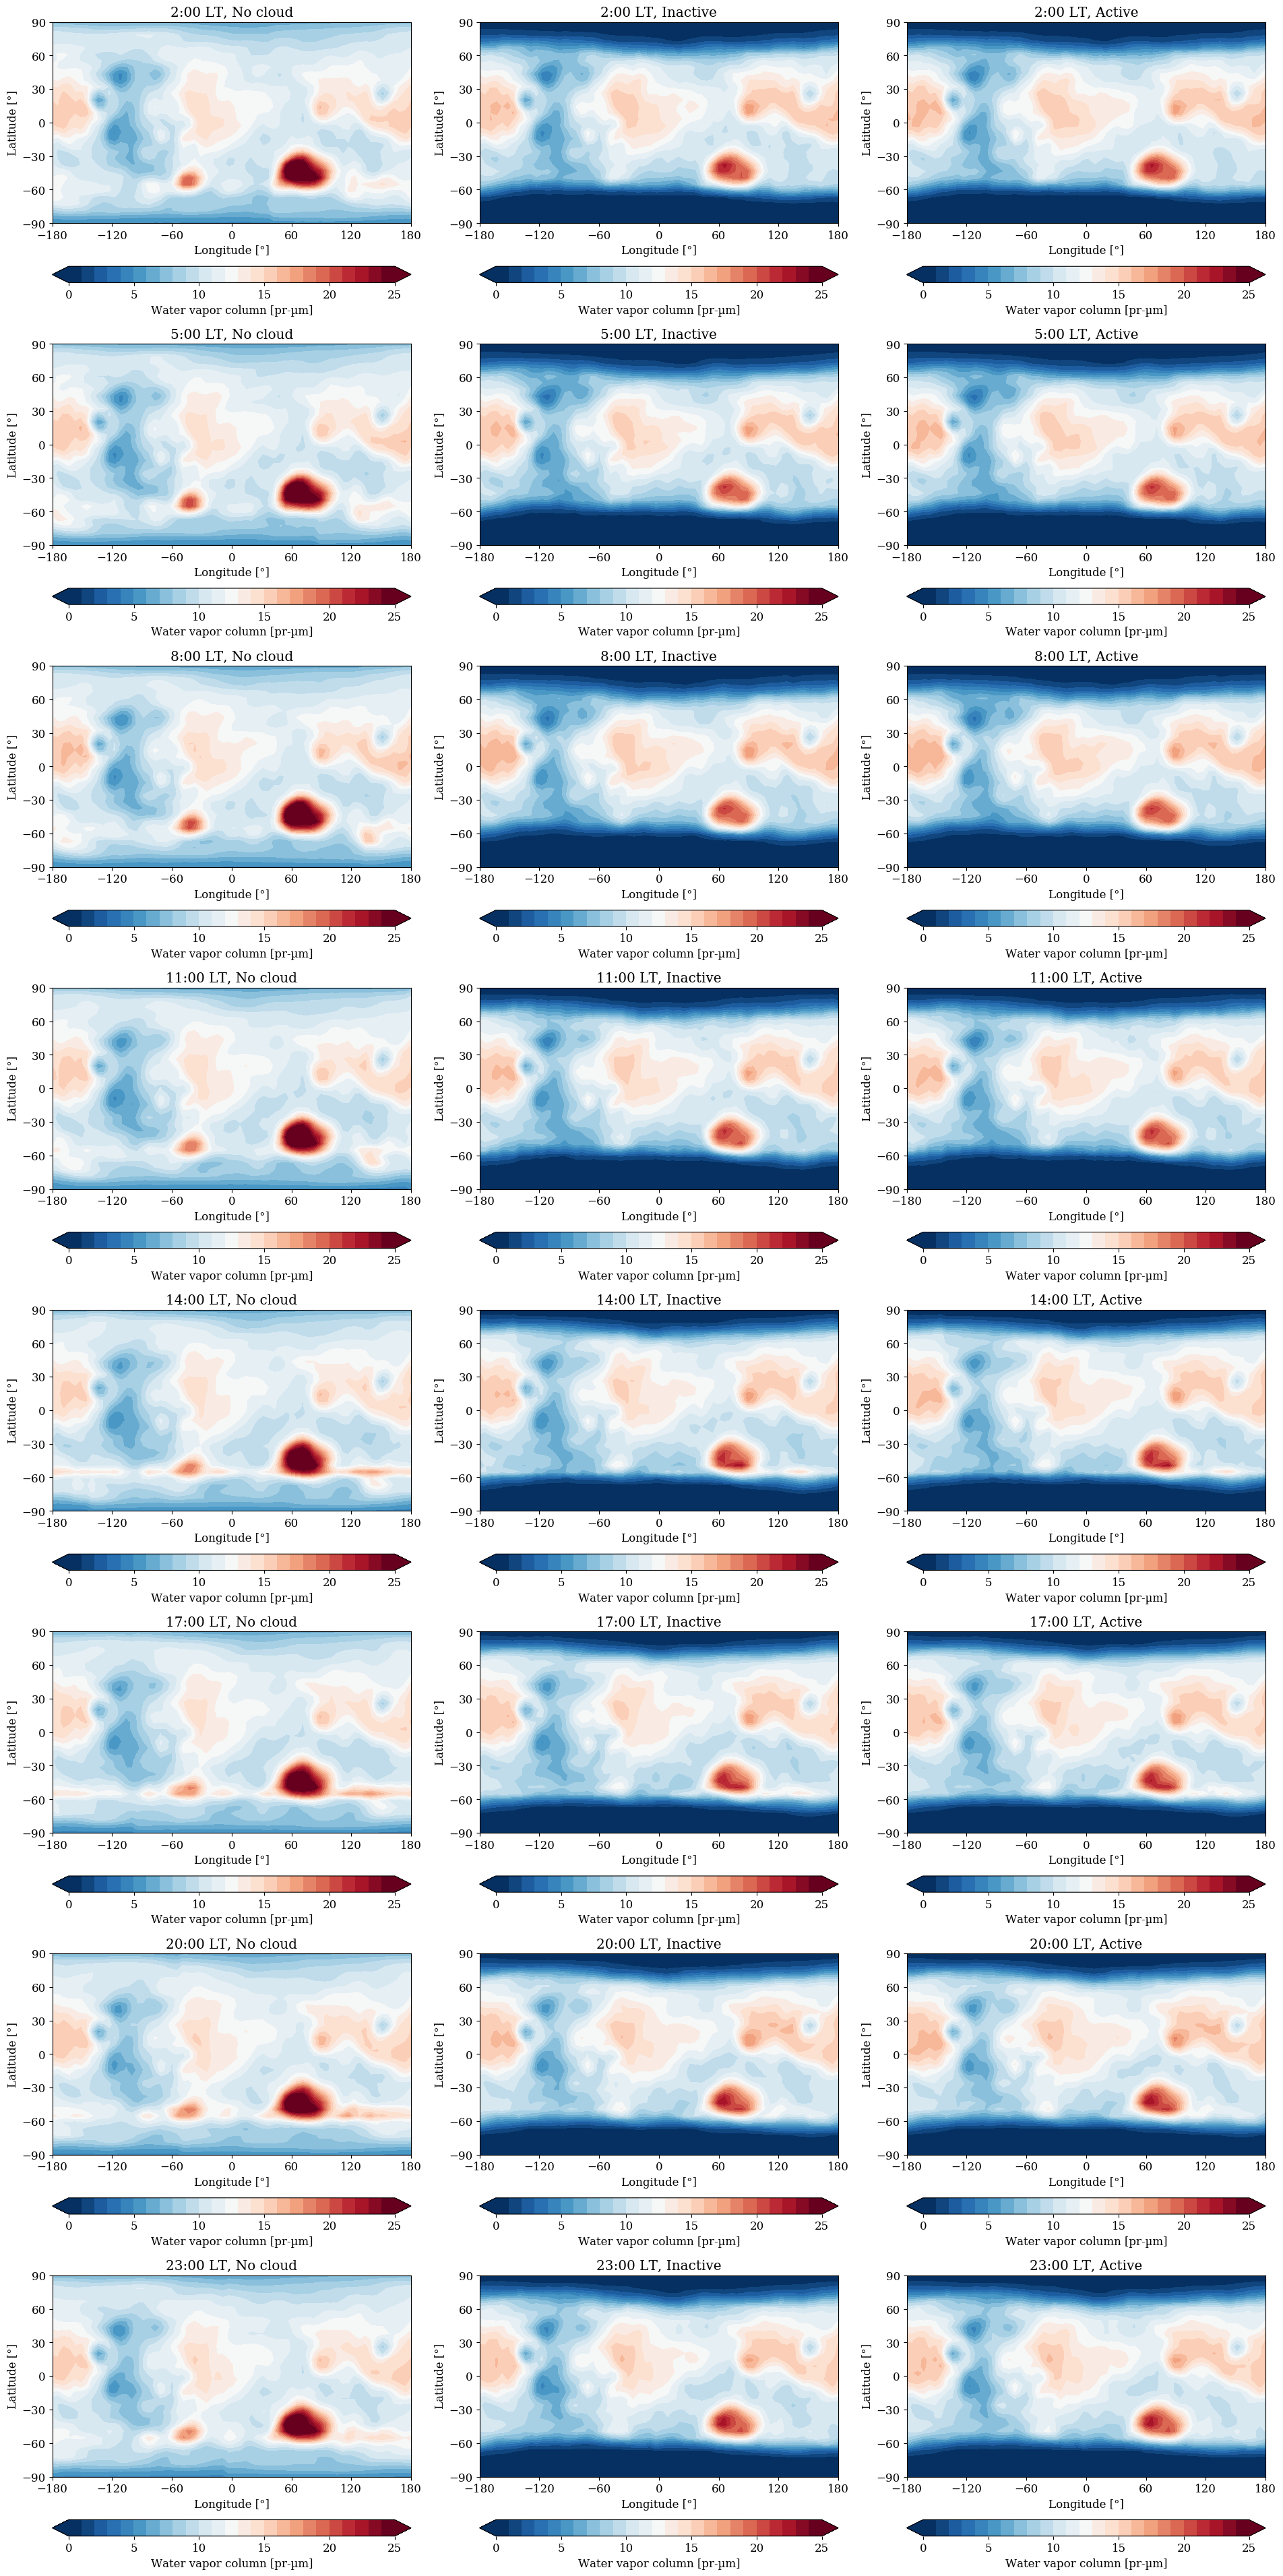

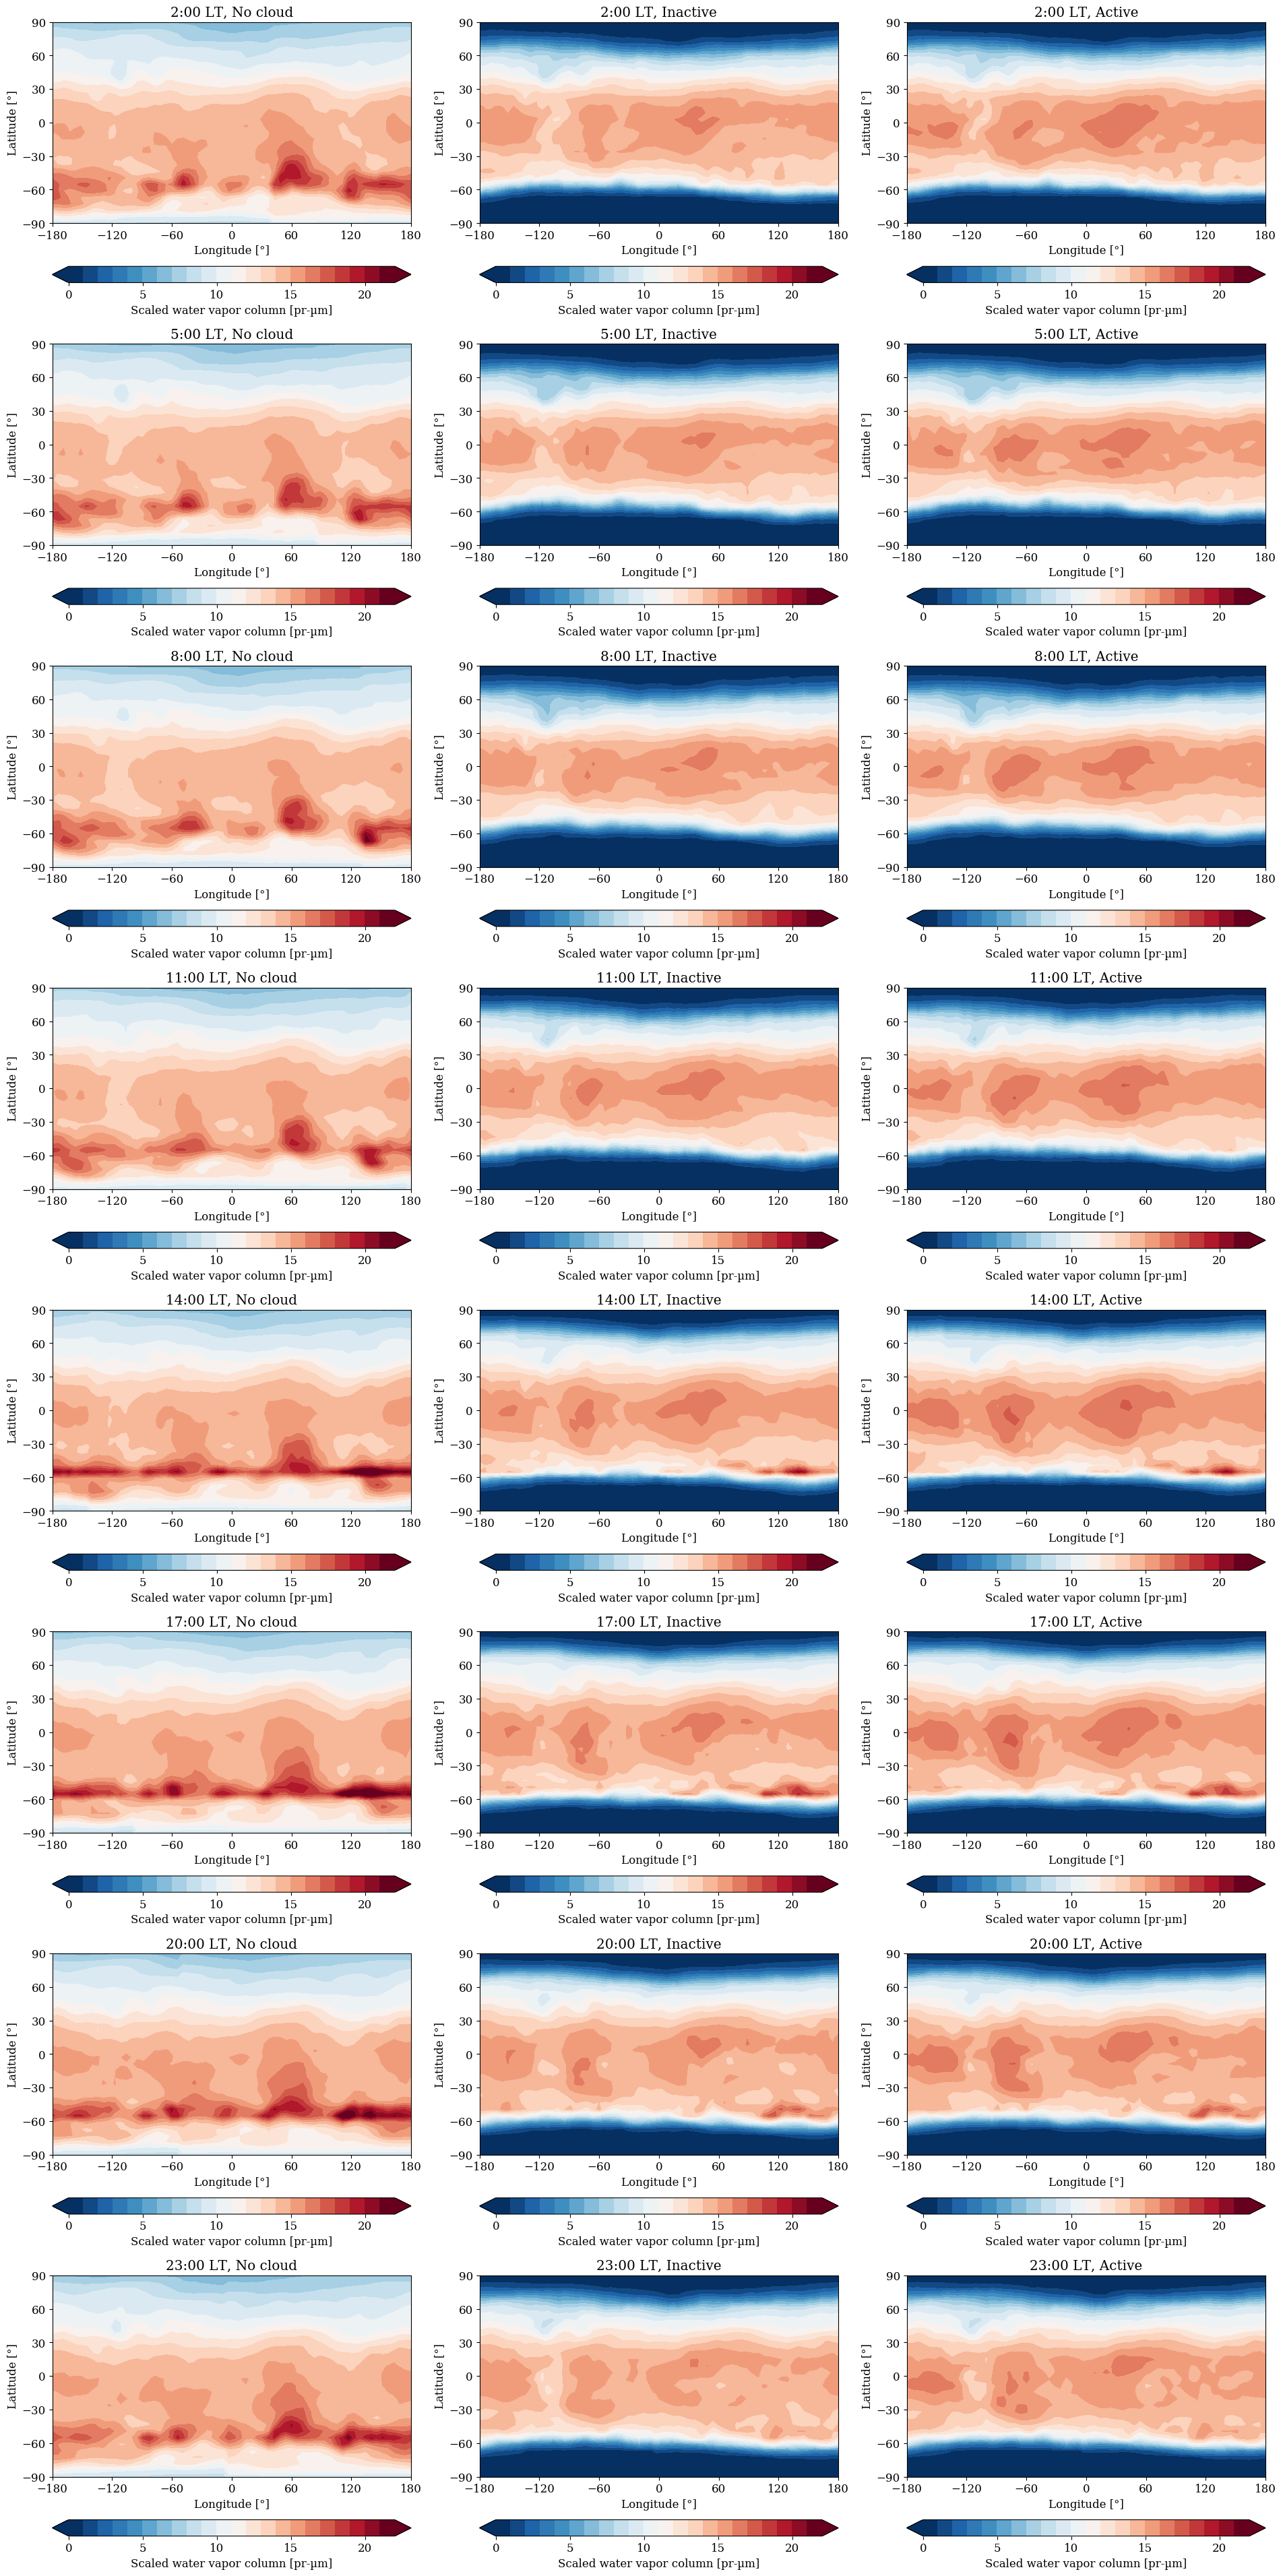

In [6]:
deg = 5.625
data_local = localtime_aligner(data,nx,deg) # Synchronize local time at all locations
data_local_ave = day_average(data_local) # 10 days average
data_local_ave_roll = roll_longitude(data_local_ave,nx) # roll longitudes 180°
#data_local_ave_zm = zonal_mean(data_local_ave) # zonal mean

wv_column = data_local_ave_roll[:,0,:,0,:,:]
scaled_wv = data_local_ave_roll[:,0,:,0,:,:]*1e6 / (data_local_ave_roll[:,1,:,0,:,:]*1e2 / 610)

titles = [
    'No cloud',
    'Inactive',
    'Active',
]
Z = data_local_ave_roll[:,0,:,0,:,:]*1e6
levels = [
    np.arange(0,25.1,1),
    np.arange(0,25.1,1),
    np.arange(0,25.1,1),
    np.arange(0,25.1,1),
    np.arange(0,25.1,1),
    np.arange(0,25.1,1),
    np.arange(0,25.1,1),
    np.arange(0,25.1,1),
]
labels = [
    r'Water vapor column [pr-µm]',
    r'Water vapor column [pr-µm]',
    r'Water vapor column [pr-µm]',
    r'Water vapor column [pr-µm]',
    r'Water vapor column [pr-µm]',
    r'Water vapor column [pr-µm]',
    r'Water vapor column [pr-µm]',
    r'Water vapor column [pr-µm]',
]
figure = draw_map(3,8,titles,nx,ny,Z,'RdBu_r',levels,labels)

Z = scaled_wv
levels = [
    np.arange(0,22.1,1),
    np.arange(0,22.1,1),
    np.arange(0,22.1,1),
    np.arange(0,22.1,1),
    np.arange(0,22.1,1),
    np.arange(0,22.1,1),
    np.arange(0,22.1,1),
    np.arange(0,22.1,1),
]
labels = [
    r'Scaled water vapor column [pr-µm]',
    r'Scaled water vapor column [pr-µm]',
    r'Scaled water vapor column [pr-µm]',
    r'Scaled water vapor column [pr-µm]',
    r'Scaled water vapor column [pr-µm]',
    r'Scaled water vapor column [pr-µm]',
    r'Scaled water vapor column [pr-µm]',
    r'Scaled water vapor column [pr-µm]',
]
figure = draw_map(3,8,titles,nx,ny,Z,'RdBu_r',levels,labels)


k,j,i =  0 0 0
k,j,i =  0 1 1


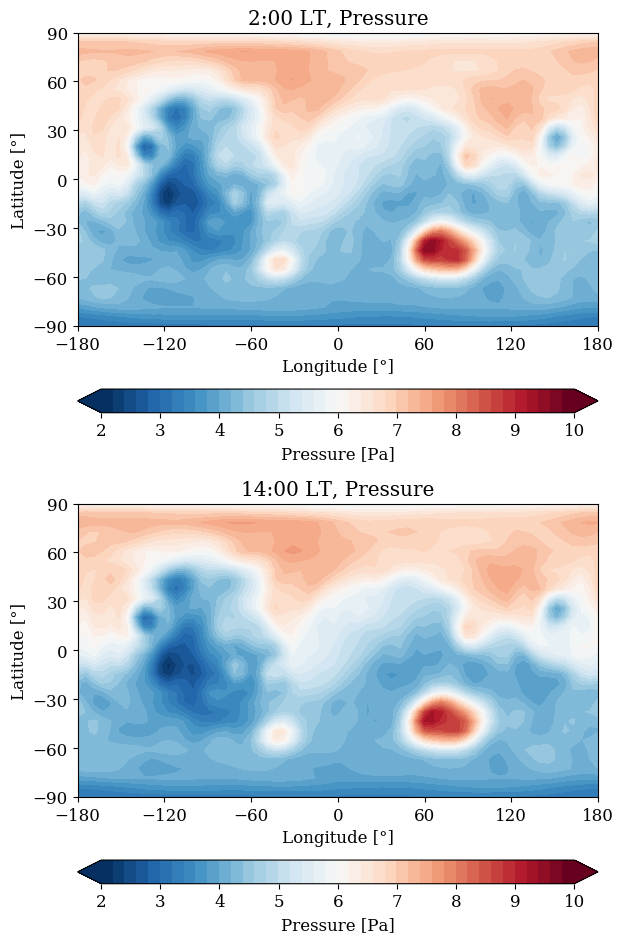

In [7]:
files = ['/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-inactive-Ls180/']
variables = ['PS-1h']
nf,nv,nd,nt,nz,ny,nx = 1,1,10,24,1,32,64
data = np.zeros((nf,nv,nd*nt*nz*ny*nx))
data = np.loadtxt(files[0]+variables[0]+'.asc')
PS = data.reshape(nf,nv,nd,nt,nz,ny,nx)
deg = 5.625
PS_local = localtime_aligner(PS,nx,deg)
PS_local_ave = day_average(PS_local)
PS_local_ave_roll = roll_longitude(PS_local_ave,nx)
PS_local_ave_zm = zonal_mean(PS_local_ave)

titles = ['Pressure','Pressure']
Z = PS_local_ave_roll[:,0,:,0,:,:]
levels = [np.arange(2,10.1,0.2),np.arange(2,10.1,0.2)]
labels = [r'Pressure [Pa]',r'Pressure [Pa]']
figure = draw_map(1,2,titles,nx,ny,Z,'RdBu_r',levels,labels)

In [8]:
files = ['/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive-nocloud/']
#files = ['/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive/']
#files = ['/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180/']
variables = [
    'RHOWTR-1h-p',
    'RHOAIR-1h-p',
    'U-1h-p',
    'pivel-1h-p',
    'QV2-1h-p',
    'QL2-1h-p',
]
nf,nv,nd,nt,nz,ny,nx = len(files),len(variables),49,24,70,32,64
nf,nv,nd,nt,nz,ny,nx = len(files),len(variables),10,24,70,32,64
data = np.zeros((nf,nv,nd*nt*nz*ny*nx))
for i in range(nf):
    for j in range(nv):
        print(files[i] + variables[j] + '.asc')
        data[i,j] = np.loadtxt(files[i] + variables[j] + '.asc')
data = data.reshape(nf,nv,nd,nt,nz,ny,nx)

/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive-nocloud/RHOWTR-1h-p.asc


/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive-nocloud/RHOAIR-1h-p.asc
/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive-nocloud/U-1h-p.asc
/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive-nocloud/pivel-1h-p.asc
/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive-nocloud/QV2-1h-p.asc
/mnt/dram2/koba/data/MIRAI1k-active-adsinhom-Ls180-inactive-nocloud/QL2-1h-p.asc


In [9]:
latitudes = np.round(np.linspace(-85,85,32),2)
latitudes = latitudes[::-1]
print(latitudes)
longitudes = np.round(np.linspace(-180,180,64),2)
print(longitudes)

deg = 5.625
data_local = localtime_aligner(data,nx,deg) # Synchronize local time at all locations
data_local_ave = day_average(data_local) # 10 days average
data_local_ave_roll = roll_longitude(data_local_ave,nx) # roll longitudes 180°
#data_local_ave_zm = zonal_mean(data_local_ave) # zonal mean

rho_H2O = data_local_ave_roll[0,0,:,:,:,:]
rho_air = data_local_ave_roll[0,1,:,:,:,:]
u       = data_local_ave_roll[0,2,:,:,:,:]
omega   = data_local_ave_roll[0,3,:,:,:,:]
qv      = data_local_ave_roll[0,4,:,:,:,:]
ql      = data_local_ave_roll[0,5,:,:,:,:]
w = pvel_to_w(omega, rho_air)
scaled_wv = rho_H2O * 1e8 / (PS_local_ave_roll[0,0,:,:,:,:] * 1e2 / 610)
print(w.shape)
print(scaled_wv.shape)

[ 85.    79.52  74.03  68.55  63.06  57.58  52.1   46.61  41.13  35.65
  30.16  24.68  19.19  13.71   8.23   2.74  -2.74  -8.23 -13.71 -19.19
 -24.68 -30.16 -35.65 -41.13 -46.61 -52.1  -57.58 -63.06 -68.55 -74.03
 -79.52 -85.  ]
[-180.   -174.29 -168.57 -162.86 -157.14 -151.43 -145.71 -140.   -134.29
 -128.57 -122.86 -117.14 -111.43 -105.71 -100.    -94.29  -88.57  -82.86
  -77.14  -71.43  -65.71  -60.    -54.29  -48.57  -42.86  -37.14  -31.43
  -25.71  -20.    -14.29   -8.57   -2.86    2.86    8.57   14.29   20.
   25.71   31.43   37.14   42.86   48.57   54.29   60.     65.71   71.43
   77.14   82.86   88.57   94.29  100.    105.71  111.43  117.14  122.86
  128.57  134.29  140.    145.71  151.43  157.14  162.86  168.57  174.29
  180.  ]


(24, 70, 32, 64)
(24, 70, 32, 64)


In [18]:
titles = ['No cloud']
#titles = ['Inactive']
#titles = ['Active']

lat = 21 #10,15,21
print(latitudes[lat])

choice_variables = {
    "scaled": 1,
    "density": 2,
    "mmr": 3,
    "velocity": 4,
}

choice_variable = choice_variables["scaled"]

if (choice_variable==1):
    name_variable = '_Scaleddensity_'
    Z = scaled_wv[:, :, lat, :]
    levels = [np.arange(0,201,5)]
    labels = [r'Scaled density of water vapor [$\rm kg \, m^{-3}$]']
elif (choice_variable==2):
    name_variable = '_Density_'
    Z = rho_H2O[:, :, lat, :]*1e8
    levels = [np.arange(0,151,5)]
    labels = [r'Density of water vapor [$\rm kg \, m^{-3}$]']
elif (choice_variable==3):
    name_variable = '_Massmixingratio_'
    Z = qv[:, :, lat, :]*1e6
    levels = [np.arange(0,151,5)]
    labels = [r'Water vapor mass mixing ratio [kg/kg]']
elif (choice_variable==4):
    name_variable = '_Verticalvelocity_'
    Z = w[:, :, lat, :]
    levels = [np.arange(-0.5,0.51,0.01)]
    labels = [r'Vertical velocity [$\rm m \, s^{-1}$]']
else:
    print('choice_variable should be 1/2/3/4.')

C = ql[:,:,lat,:]*1e6
contours = [np.arange(10,150.1,10)]
step=3
U = u[:,::step,lat,::step]
W = w[:,::step,lat,::step]
vertical_exag = 200

figname = 'draw_crosssection_xz_Ls180_'+str(latitudes[lat])+name_variable+titles[0]+' 2.pdf'
print(figname)
gifname = 'gif_crosssection_xz_Ls180_'+str(latitudes[lat])+name_variable+titles[0]+' 2.gif'
print(gifname)

-30.16
draw_crosssection_xz_Ls180_-30.16_Scaleddensity_No cloud 2.pdf
gif_crosssection_xz_Ls180_-30.16_Scaleddensity_No cloud 2.gif


k,j,i =  0 0 0
k,j,i =  0 1 1
k,j,i =  0 2 2
k,j,i =  0 3 3
k,j,i =  0 4 4
k,j,i =  0 5 5


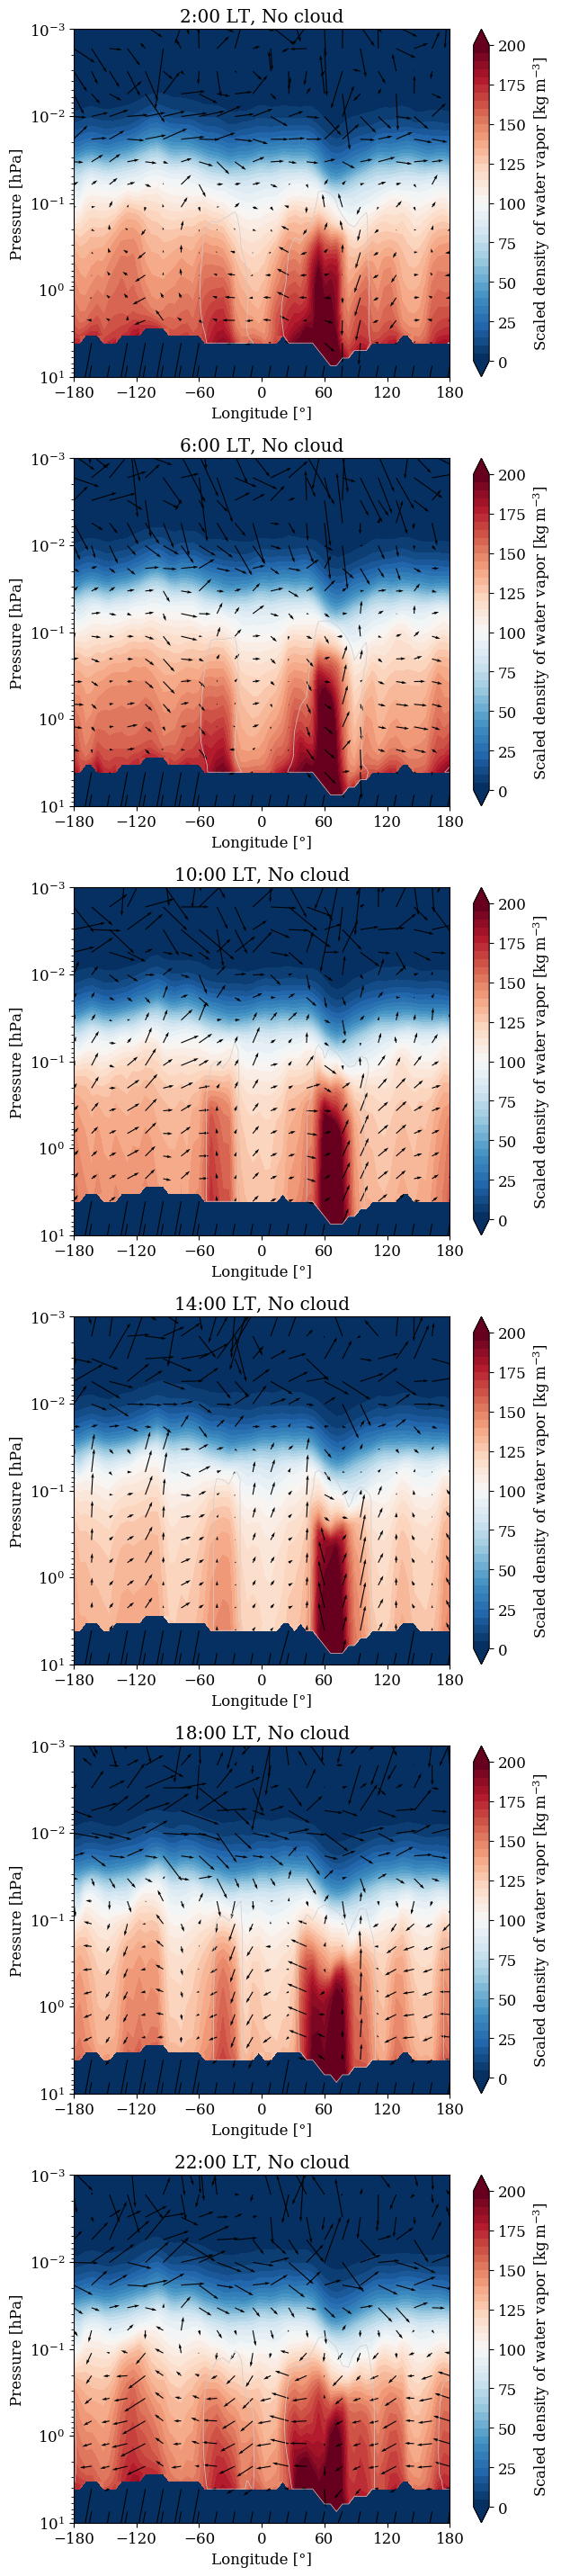

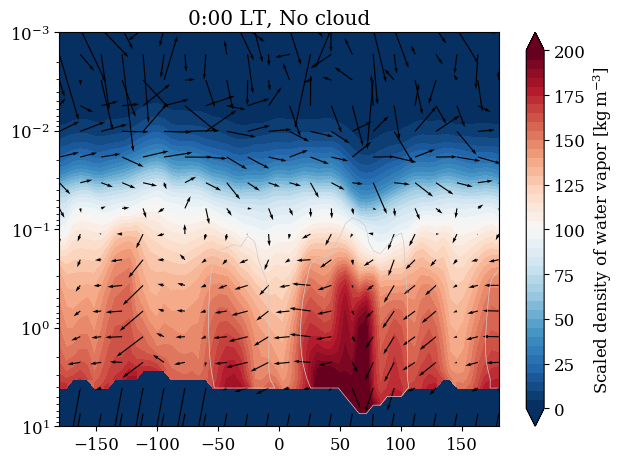

In [19]:
fig = draw_crosssection_xz(1,6,titles,nx,plev,Z,C,'RdBu_r',levels,contours,labels,step,U,W,vertical_exag,figname)

fig, ax, cmap, norm = gif_crosssection_xz(titles,nx,plev,Z,C,'RdBu_r',levels,contours,labels,step,U,W,vertical_exag,figname)
ani = animation.FuncAnimation(fig, fig_update, frames=nt, interval=100, blit=False)
ani.save(gifname, writer=PillowWriter(fps=5))


In [105]:
#data_series = data.reshape(nf,nv,nd*nt,nz,ny,nx)
#data_series_roll = roll_longitude(data_series,nx) # roll longitudes 180°
#PS_series = PS.reshape(1,1,nd*nt,1,ny,nx)
#PS_series_roll = roll_longitude(PS_series,nx) # roll longitudes 180°
#
#rho_H2O = data_series_roll[0,0,24*9:,:,:,:]
#rho_air = data_series_roll[0,1,24*9:,:,:,:]
#u       = data_series_roll[0,2,24*9:,:,:,:]
#omega   = data_series_roll[0,3,24*9:,:,:,:]
#qv      = data_series_roll[0,4,24*9:,:,:,:]
#ql      = data_series_roll[0,5,24*9:,:,:,:]
#w = pvel_to_w(omega, rho_air)
#scaled_wv = rho_H2O * 1e8 / (PS_series_roll[0,0,24*9:,:,:,:] * 1e2 / 610)
#print(w.shape)
#print(scaled_wv.shape)

In [106]:
#titles = ['No cloud']
#titles = ['Inactive']
#titles = ['Active']
#
#lat = 10 # 10,15,21
#print(latitudes[lat])
#
#choice_variables = {
#    "scaled": 1,
#    "density": 2,
#    "mmr": 3,
#    "velocity": 4,
#}
#
#choice_variable = choice_variables["scaled"]
#
#if (choice_variable==1):
#    name_variable = '_Scaleddensity_'
#    Z = scaled_wv[:, :, lat, :]
#    levels = [np.arange(0,201,5)]
#    labels = [r'Scaled density of water vapor [$\rm kg \, m^{-3}$]']
#elif (choice_variable==2):
#    name_variable = '_Density_'
#    Z = rho_H2O[:, :, lat, :]*1e8
#    levels = [np.arange(0,151,5)]
#    labels = [r'Density of water vapor [$\rm kg \, m^{-3}$]']
#elif (choice_variable==3):
#    name_variable = '_Massmixingratio_'
#    Z = qv[:, :, lat, :]*1e6
#    levels = [np.arange(0,151,5)]
#    labels = [r'Water vapor mass mixing ratio [kg/kg]']
#elif (choice_variable==4):
#    name_variable = '_Verticalvelocity_'
#    Z = w[:, :, lat, :]
#    levels = [np.arange(-0.5,0.51,0.01)]
#    labels = [r'Vertical velocity [$\rm m \, s^{-1}$]']
#else:
#    print('choice_variable should be 1/2/3/4.')
#
#C = ql[:,:,lat,:]*1e6
#contours = [np.arange(10,150.1,10)]
#step=3
#U = u[:,::step,lat,::step]
#W = w[:,::step,lat,::step]
#vertical_exag = 200
#
#figname = 'draw_crosssection_xz_series_Ls180_'+str(latitudes[lat])+name_variable+titles[0]+'.pdf'
#print(figname)
#gifname = 'gif_crosssection_xz_series_Ls180_'+str(latitudes[lat])+name_variable+titles[0]+'.gif'
#print(gifname)

In [107]:
#fig = draw_crosssection_xz(1,6,titles,nx,plev,Z,C,'RdBu_r',levels,contours,labels,step,U,W,vertical_exag,figname)
#
#fig, ax, cmap, norm = gif_crosssection_xz(titles,nx,plev,Z,C,'RdBu_r',levels,contours,labels,step,U,W,vertical_exag,figname)
#ani = animation.FuncAnimation(fig, fig_update, frames=nt, interval=100, blit=False)
#ani.save(gifname, writer=PillowWriter(fps=5))


In [20]:
data_ave = day_average(data) # 10 days average
data_ave_roll = roll_longitude(data_ave,nx) # roll longitudes 180°
PS_ave = day_average(PS) # 10 days average
PS_ave_roll = roll_longitude(PS_ave,nx) # roll longitudes 180°

rho_H2O = data_local_ave_roll[0,0,:,:,:,:]
rho_air = data_local_ave_roll[0,1,:,:,:,:]
u       = data_local_ave_roll[0,2,:,:,:,:]
omega   = data_local_ave_roll[0,3,:,:,:,:]
qv      = data_local_ave_roll[0,4,:,:,:,:]
ql      = data_local_ave_roll[0,5,:,:,:,:]
w = pvel_to_w(omega, rho_air)
scaled_wv = rho_H2O * 1e8 / (PS_local_ave_roll[0,0,:,:,:,:] * 1e2 / 610)
print(w.shape)
print(scaled_wv.shape)

(24, 70, 32, 64)
(24, 70, 32, 64)


In [33]:
titles = ['No cloud']
#titles = ['Inactive']
#titles = ['Active']

lat,lon = 21,36 #10,15,21/11,36
print(latitudes[lat])
print(longitudes[lon])

choice_variables = {
    "scaled": 1,
    "density": 2,
    "mmr": 3,
    "velocity": 4,
}

choice_variable = choice_variables["scaled"]

if (choice_variable==1):
    name_variable = '_Scaleddensity_'
    Z = scaled_wv[:, :, lat, lon].T
    levels = [np.arange(0,201,5)]
    labels = [r'Scaled density of water vapor [$\rm kg \, m^{-3}$]']
elif (choice_variable==2):
    name_variable = '_Density_'
    Z = rho_H2O[:, :, lat, lon].T*1e8
    levels = [np.arange(0,151,5)]
    labels = [r'Density of water vapor [$\rm kg \, m^{-3}$]']
elif (choice_variable==3):
    name_variable = '_Massmixingratio_'
    Z = qv[:, :, lat, lon].T*1e6
    levels = [np.arange(0,151,5)]
    labels = [r'Water vapor mass mixing ratio [kg/kg]']
elif (choice_variable==4):
    name_variable = '_Verticalvelocity_'
    Z = w[:, :, lat, lon].T
    levels = [np.arange(-0.5,0.51,0.01)]
    labels = [r'Vertical velocity [$\rm m \, s^{-1}$]']
else:
    print('choice_variable should be 1/2/3/4.')

C = ql[:,:,lat,lon].T*1e6
contours = [np.arange(10,150.1,10)]
step=3
U = u[::step,::step,lat,lon].T
W = w[::step,::step,lat,lon].T
vertical_exag = 200

figname = 'draw_crosssection_tz_Ls180_'+str(latitudes[lat])+str(longitudes[lon])+name_variable+titles[0]+' 2.pdf'
print(figname)
gifname = 'gif_crosssection_tz_Ls180_'+str(latitudes[lat])+str(longitudes[lon])+name_variable+titles[0]+' 2.gif'
print(gifname)

-30.16
25.71
draw_crosssection_tz_Ls180_-30.1625.71_Scaleddensity_No cloud 2.pdf
gif_crosssection_tz_Ls180_-30.1625.71_Scaleddensity_No cloud 2.gif


k,j,i =  0 0 0


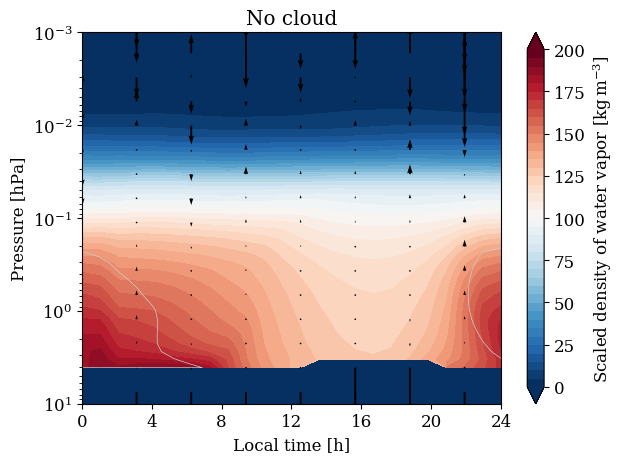

In [34]:
fig = draw_crosssection_tz(1,1,titles,plev,Z,C,'RdBu_r',levels,contours,labels,step,U,W,vertical_exag,figname)